### K Means

&nbsp;

K means is the easiest form of unsupervised learning.

Unsupervised learning is a type of self-organized learning that helps find previously unknown patterns in data set without pre-existing labels.

Supervised learning is trying to find a boundary to separate data with different properties.

Unsupervised learning is trying to aggregate data with similar properties.

Think of unsupervised learning as a bottom-up approach and supervised learning is a top-down approach.

Unsupervised learning is mostly used in cluster problems to sort data into different categories.

For more technical details, feel free to read the following link (even though it is in R)

https://towardsdatascience.com/k-means-a-complete-introduction-1702af9cd8c

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import imageio
import random as rd

In [2]:
import os
os.chdir('h:/')

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
#euclidean distance is the measure of the distance between two points in geometry
#other measures include manhattan distance
#actually u can use np.linalg.norm to save u time
def euclidean_distance(p1,p2):
    
    assert len(p1)==len(p2),"p1 and p2 should be the same dimension"
    
    temp=sum([i**2 for i in np.subtract(p1,p2)])
    
    return temp**0.5

In [5]:
#for kmeans, clf.score doesnt return the accuracy
#becuz its unsupervised learning
#there is no cross validation, no known labels
#the only way to detect the accuracy is vote of the majority
#for each label given by kmeans
#we check which iris type is the majority
#we consider the majority as the correct classification
#all we need to do is to count the minority
def get_accuracy(data,class_):
    
    df=copy.deepcopy(data)
    
    #use dictionary to keep track of everything
    d={}
    
    #counting
    for i in df['type'][df['label']==class_].unique():
        d[i]=df['type'][df['label']==class_].tolist().count(i)
    
    #comparison
    temp=-1
    lbl=None
    for i in d:
        if d[i]>temp:
            lbl=i
            temp=d[i]

    return len(df['type'][df['label']==class_][df['type']!=lbl])

In [6]:
#create random centroids
#centroids are bounded by the extreme value of our data points
def random_centroid(data):
    
    x=copy.deepcopy(data)
    
    centroid=[]
    
    #the dimension of centroid should align to training dataset
    #*100 then /100 to get decimal numbers
    for i in x:
        rdnum=rd.randint(int(min(x[i])*100),
                         int(max(x[i])*100))/100
        centroid.append(rdnum)
        
    return centroid

In [7]:
#the logic of kmeans is very intuitive
#assuming we are using 3 centroids (the selection of k is another topic)
#we insert 3 random centroids into the data
#we calculate the euclidean distance from each data point to each centroid
#each data point is mapped to the closest centroid
#once classification is done, we move the centroids to the centre of the cluster
#we keep repeating three steps above until the centroids dont move any move
#or the iteration has reached the limit set by us, which is 50 by default
#k means is simple but it has some shortcomings
#it does not always converge to the local optima
#if you run a few iterations you will see different results
#and its boundary is always linear
def kmeans(data1,data2,knum=3,itrlimit=50,fixed_pos=True,
           show_acc=False,show_viz=False,genr_gif=False):
    
    x=copy.deepcopy(data1)
    df=copy.deepcopy(data2)
    
    if fixed_pos==True:
        centroids=[]
        var=locals()
        
        #using fixed position of centroids
        #centroids will be scattered on the diagonal hyperspace
        for i in x:
            var[i.replace(' ','_')]=(max(x[i])-min(x[i]))/(knum+2)
        
        for j in range(1,knum+1):
            centroids.append([min(x[i])+var[i.replace(' ','_')]*(j) for i in x])

    else:
        #create random centroids
        centroids=[]
        for j in range(knum):

            centroid=random_centroid(x)

            #no duplicates
            while centroid in centroids:
                centroid=random_centroid(x)

            centroids.append(centroid)

    #converge is used to stop the loop when centroids dont move any more
    #counter is to stop the infinite iteration
    #on a very rare occasion, centroids would swing between 2 clusters
    #in that sense, we stop the iteration
    converge=False
    counter=0
    
    
    while not converge:
        
        #calculate distance
        labels=[]
        for i in range(len(x)):
            point=x.loc[i].tolist()

            distance=[]

            for j in centroids:

                distance.append(euclidean_distance(point,j))
            
            #set label of each data point as the closest centroid
            labels.append(distance.index(min(distance)))
                
        x['label']=labels
        df['label']=labels
        
        #visualization
        if show_viz==True or genr_gif==True:            
            
            ax=plt.figure().add_subplot(111)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.scatter(x['dimension 1'],x['dimension 2'],
                        c=labels,alpha=0.2,s=50,label='clusters')

            plt.scatter([i[0] for i in centroids],
                        [i[1] for i in centroids],
                        c=range(knum),
                        s=200,marker='*',
                        edgecolors='k',
                        label='centroids')

            plt.ylabel('Dimension 2')
            plt.xlabel('Dimension 1')
            plt.title('K Means')
            plt.legend(loc='lower right')
            
            if genr_gif==True:
                #this line is used to create gif animation
                plt.savefig('kmeans%d.png'%(counter))
                plt.show()
            elif show_viz==True:
                plt.show()
            else:
                pass
        
        #check if converged
        centroids_prev=copy.deepcopy(centroids)
        centroids=[]

        for i in range(knum):
            
            #sometimes one of the centroids is too far from any data point
            #we have to reset the centroid
            if x[x['label']==i].empty:

                centroid=random_centroid(x)
                while centroid in centroids:
                    centroid=random_centroid(x)
                centroids.append(centroid)
            
            #otherwise we update the centroids
            #we move them to the centre of the cluster
            else:
                centroids.append(np.mean(x[x['label']==i]).tolist())    
        
        #two conditions to stop the iteration
        #either converged or reaching iteration limit
        counter+=1
        if centroids==centroids_prev or counter>=itrlimit:
            converge=True
    
    #print accuracy
    if show_acc==True:        
        
        erreur=0

        for i in range(knum):
            erreur+=get_accuracy(df,i)

        accuracy=1-erreur/len(df)

        print('accuracy: %s'%(accuracy))
    
    #create gif
    if genr_gif==True:
        
        filenames=['kmeans%d.png'%(i) for i in range(counter)] 
        images=list(map(lambda filename:imageio.imread(filename),
                        filenames))
        imageio.mimsave('kmeans.gif',images,duration=0.8)
    
    return labels

In [8]:
#kmeans implemented by sklearn
def skl_kmeans(data1,data2,n=3):
    
    x=copy.deepcopy(data1)
    df=copy.deepcopy(data2)
    
    clf=KMeans(n)
    clf.fit(x)
    
    df['label']=clf.predict(x)
    
    erreur=0

    for i in range(len(set(clf.labels_))):
        erreur+=get_accuracy(df,i)

    accuracy=1-erreur/len(x)

    print('accuracy: %s'%(accuracy))

In [9]:
df=pd.read_csv('iris.csv')

In [10]:
x=pd.concat([df['sepal length'], \
                 df['sepal width'], \
                 df['petal length'],\
                 df['petal width']],axis=1)

In [11]:
#for the purpose of visualization
#we reduce 4 dimensions to 2

dims=2

x=PCA(n_components=dims).fit_transform(x)

In [12]:
x=pd.DataFrame(x,columns=[f'dimension {i}' for i in range(1,dims+1)])

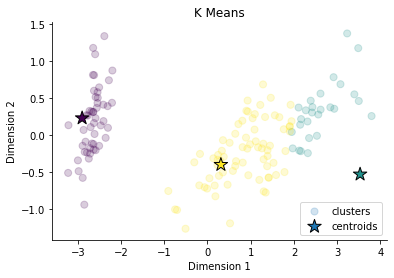

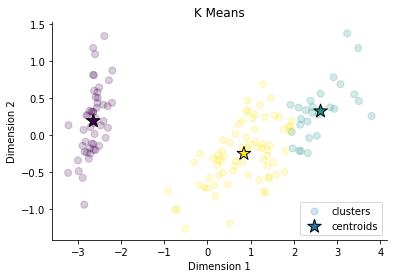

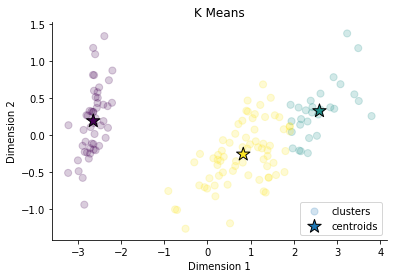

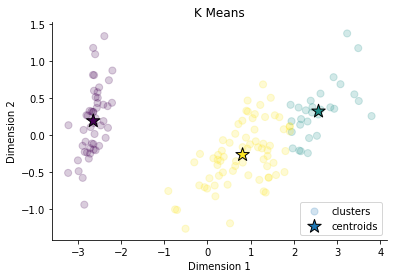

accuracy: 0.86


In [13]:
df['label']=kmeans(x,df,show_acc=True,
                   show_viz=True,fixed_pos=False,
                   genr_gif=True)

In [14]:
skl_kmeans(x,df)

accuracy: 0.8866666666666667


![alt text](./preview/kmeans.gif)

&nbsp;

### Selection of K

&nbsp;

The key part of K Means is the selection of K.

There are many metrics used in unsupervised learning.

Here we only talk about 3 of the most common ones for K Means.

All of them are brute force calculation.

Run an iteration of different amounts of centroids and use some metrics to evaluate the effect.

#### Elbow Method

&nbsp;

It is called inertia in scikit-learn.

It is the computation of within-cluster sum of squared error (WSSE).

WSSE refers to the sum of the euclidean distance from each data point to its underlying centroid.

It is quite intuitive that the overall distance gets smaller as we increase the amount of centroids.

Think of it as more variables lead to the increase of R squared in OLS.

The idea of elbow method is to find the optimal spot where you have a reasonable amount of centroid and smaller overall distance.

It is where inertia curve takes a sharp decline.

We call the critical point 'The Elbow'.

To identify the sweet spot, we create a new line by connecting the start of inertia curve to the end.

The G spot exists at the largest perpendicular distance from the newly formed line to inertia curve.

In [15]:
#plot two curves on separate axis
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
    sec_color='b',fig_size=(10,5),x_label='',
    y_label1='',y_label2='',grid=False,title='',
    legend1='',legend2=''):
    
    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)    

    ax.set_xlabel(x_label)
    
    #differentiate two y axis by different colors
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15
    
    #legend of y1 goes to the left
    plt.legend(loc=3)
    
    #the crucial part of dual axis plot
    ax2 = ax.twinx()

    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.plot(xaxis[data2.index(max(data2))],max(data2),
             marker='*',markersize=25,lw=0,color='#b23850',
             alpha=0.7,label='optimal')
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15

    fig.tight_layout()
    plt.legend(loc=4)
    plt.grid(grid)
    plt.title(title)
    plt.show()

In [16]:
#using geometry to calculate the perpendicular distance
def get_distance(x,y,a,b):
    
    temp1=y-x*a-b
    temp2=(a**2+1)**0.5
    
    return np.abs(temp1/temp2)

#simple solution to get coefficients of the equation
def get_line_params(x1,y1,x2,y2):
    
    a=(y1-y2)/(x1-x2)
    b=y1-a*x1
    
    return a,b

In [17]:
#calculate intra-cluster sum of squared error
#some people call it within-cluster sum of squared error
#it is the sum of the euclidean distance from each point to its underlying centroid
#in sklearn, it is an attribute called inertia
def get_inertia(data):
    
    x=copy.deepcopy(data)[[i for i in data.columns if i!='label']]
    
    wsse=[]
    
    for i in data['label'].unique():
        
        #centroid is basically the mean of a cluster
        centroid=np.mean(x[data['label']==i]).tolist()

        for j in x.loc[data['label']==i].index:
            wsse.append(euclidean_distance(x.loc[j].tolist(),
                               centroid))
        
    return sum(wsse) 

In [18]:
#calculate wsse
inertia=[]

for i in range(2,8):
    x['label']=kmeans(x[[i for i in x.columns if i!='label']],
                      df,knum=i)
    inertia.append(get_inertia(x))

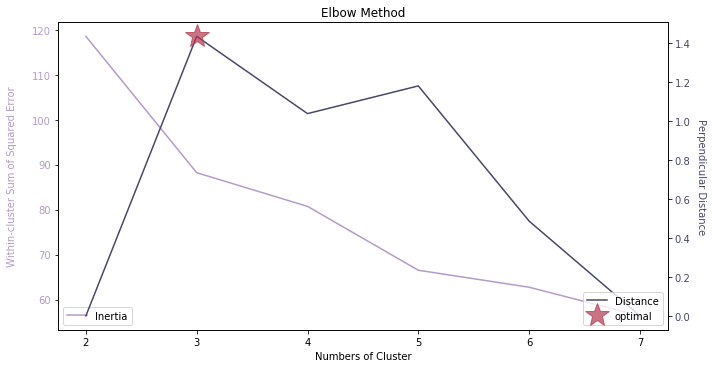

In [19]:
#connect the start of inertia curve to the end
a,b=get_line_params(0,inertia[0],len(inertia)-1,inertia[-1])

#calculate the perpendicular distance 
#from each point on inertia curve to the straight line
distance=[]
for i in range(len(inertia)):    
    distance.append(get_distance(i,inertia[i],a,b))

#use dual axis visualization
dual_axis_plot(np.arange(2,8),inertia,distance,
               x_label='Numbers of Cluster',
               y_label1='Within-cluster Sum of Squared Error',
               y_label2='Perpendicular Distance',
               legend1='Inertia',legend2='Distance',
               title='Elbow Method',
               fst_color='#b39bc8',sec_color='#464866')

#### Silhouette Score

&nbsp;

Silhouette score or silhouette coefficient is a more scientific approach to determine the amount of the clusters.

For the details of the computation, please refer to Wikipedia

https://en.wikipedia.org/wiki/Silhouette_(clustering)

The numerator consists of similarity and dissimilarity.

Similarity implies the density of inside the cluster.

The smaller the better.

Dissimilarity implies the distance among clusters.

The larger the better (think of it as functional margin in svm).

The overall silhouette score proposed by Kaufman represents the mean silhouette over the entire dataset.

We select K to maximize the silhouette score.

In [20]:
#calculate mean distance from one point to a cluster
#it is the mean of euclidean distance from one point to all the points in the cluster
def mean_distance(point,dataset):
    
    distance_list=[]
    
    assert not dataset.empty,'empty dataset'
    
    for i in dataset.index:
        
        #make sure we dont include the point itself
        if dataset.loc[i].tolist()!=point:
             distance_list.append(
                 euclidean_distance(point,
                                    dataset.loc[i].tolist()))
    
    #if one cluster has only one element which is the point itself
    #we will return zero
    if len(dataset)==1 and dataset.iloc[0].tolist()==point:
        return 0
    
    #we raise warning here
    #because np.mean([]) returns np.nan
    #it will cause a huge problem for silhouette computation
    import warnings
    warnings.simplefilter('error')
    
    return np.mean(distance_list)

In [21]:
#silhouette coefficient is the maximum value of the mean silhouette for each label
#in sklearn, it is sklearn.metrics.silhouette_score
#to calculate silhouette for each data point in the dataset
#we need to create multiple loops
#so the time complexity of silhouette score is way higher than other metrics
def silhouette_coefficient(data):
    
    x=copy.deepcopy(data)[[i for i in data.columns if i!='label']]
    cols=x.columns.tolist()
    
    #if there is only one cluster, silhouette score is zero
    if len(data['label'].unique())==1:
        return 0
    
    silhouette=[]
    
    #calculate silhouette for each data point
    for i in range(len(x)):
        lbl=data['label'][i]
    
        #similarity is mean distance from one point to every other point within the same cluster
        similarity=mean_distance(x[cols].loc[i].tolist(),
                                 x[cols].loc[data['label']==lbl])

        temp=[]
        
        otherlbl=[i for i in set(data['label']) if i!=lbl]
        

        #dissimilarity is mean distance from one point to all the points in the other clusters
        for j in otherlbl:
            
            temp.append(mean_distance(x[cols].loc[i].tolist(),
                                      x[cols].loc[data['label']==j]))

        dissimilarity=min(temp)

        silhouette.append((dissimilarity-similarity)/max(similarity,dissimilarity))
    
    x['silhouette']=silhouette

    silhouette=[]

    for i in set(data['label']):

        silhouette.append(np.mean(x['silhouette'][data['label']==i].tolist()))
    
    return max(silhouette)

In [22]:
#calculate silhouette score
silhouette_score=[]
for i in range(2,8):

    #avoid using label as one of the features
    x['label']=kmeans(x[[i for i in x.columns if i!='label']],
                      df,knum=i)

    silhouette_score.append(silhouette_coefficient(x))

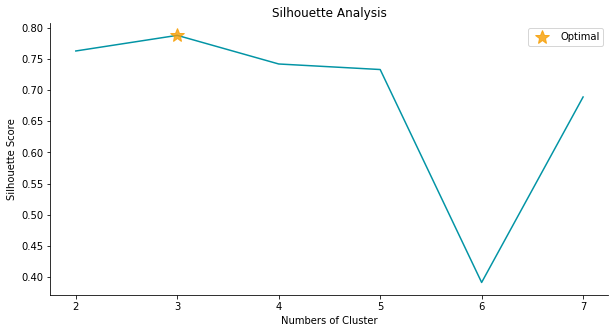

In [23]:
#visualize silhouette
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
            
plt.plot([i for i in range(2,8)],silhouette_score,c='#0294a5',)
plt.plot(silhouette_score.index(max(silhouette_score))+2,
         max(silhouette_score),lw=0,c='#f79e02',alpha=0.8,
         marker='*',markersize=15,label='Optimal')

plt.legend(loc=0)
plt.ylabel('Silhouette Score')
plt.xlabel('Numbers of Cluster')
plt.title('Silhouette Analysis')
plt.show()

### Gap Statistic

&nbsp;

Gap statistic is a relatively new metric compared to the others.

It was invented 20 years ago by some scholars from Stanford University.

Sklearn has not included gap statistic in its package.

Gap statistic is the logarithm difference between mean WSSE of reference data and WSSE of real data.

We select K to satisfy the gap statistic K plus standard deviation of reference data WSSE K+1 is larger than the gap statistic K+1.

Similar to autocorrelation plot in time series analysis, we pick the smallest K.

For coding reference, feel free to check anaconda notebook

https://anaconda.org/milesgranger/gap-statistic/notebook

For math reference, feel free to check the original paper

https://statweb.stanford.edu/~gwalther/gap

In [24]:
#there are two ways to generate the reference data
#here we take the first approach from the paper
#using uniform distribution for simplicity
#the distribution is bounded by the extreme value of the original dataset
def get_reference_data(x):
    
    montecarlo=[]   
    for i in range(len(x)):    
        temp=[]
        for j in x.columns:
            if j!='label':
                rdnum=rd.uniform(min(x[j]),
                                 max(x[j]))
                temp.append(rdnum)
        montecarlo.append(temp)
    
    output=pd.DataFrame()
    
    for i in x.columns:
        if i!='label':
            output[i]=[j[x.columns.tolist().index(i)] for j in montecarlo]
            
    return output

In [25]:
#use monte carlo simulation to generate reference data
simulation=10

var=locals()

for i in range(simulation):

    var['ref'+str(i)]=get_reference_data(x[[i for i in x.columns if i!='label']])

In [26]:
gap_stat=[]
gap_std=[]
for i in range(2,8):
    
    #avoid using label as one of the features
    x['label']=kmeans(x[[i for i in x.columns if i!='label']],
                      df,knum=i)
    
    #get expectation of gap statistic from all reference data
    mc_simu=[]
    for j in range(simulation):
        var['ref'+str(j)]['label']=kmeans(var['ref'+str(j)][[i for i in x.columns if i!='label']],
                                   x,knum=i)
    
        mc_simu.append(get_inertia(var['ref'+str(j)])) 
    
    gap_stat.append(np.mean([np.log(i) for i in mc_simu])-np.log(get_inertia(x)))
    gap_std.append((1+1/simulation)**0.5*np.std([np.log(i) for i in mc_simu]))

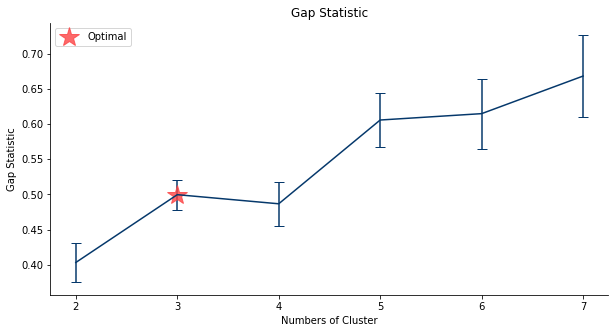

In [27]:
#visualize gap statistic
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
            
plt.errorbar([i for i in range(2,8)],gap_stat,gap_std,
             c='#05386b',capsize=5)
ind=None
for i in range(len(gap_stat)-1):
    if gap_stat[i]+gap_std[i+1]>gap_stat[i+1]:
        ind=i
        break

plt.plot(ind+2,gap_stat[ind],
             lw=0,c='#fc4445',alpha=0.8,
             marker='*',markersize=20,label='Optimal')

plt.legend(loc=0)
plt.ylabel('Gap Statistic')
plt.xlabel('Numbers of Cluster')
plt.title('Gap Statistic')
plt.show()